# LlamaIndex Deep Research Project

Welcome to LlamaIndex! In this notebook we'll be walking step-by-step through building agentic workflows, culminating in building a Deep Research workflow.

This notebook has 4 main sections:

* Using AgentWorkflow
* Building a multi-agent system with AgentWorkflow
* Building agentic Workflows
* Building a multi-agent system with Workflows

In LlamaIndex, `Workflow`s are the building blocks of putting together an agent or a multi-agent system. To get you up and running quickly, we have a pre-built Workflow called the `AgentWorkflow` that handles a lot of common agent use cases and allows you to focus on the specifics of your implementation. Later, we drop down one level to Workflows themselves and show how to build one from scratch.

To start off, we'll create an AgentWorkflow with a single agent, and use that to cover the basic functionality of the `AgentWorkflow` class.

In [1]:
%pip install llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 5.4 MB/s eta 0:00:00


## Getting an LLM

The engine of any agent is the LLM that does the reasoning and text processing. To get started, we'll need access to an LLM.

In this example, we'll be using `OpenAI` as our LLM. LlamaIndex supports more than 80 different LLM providers, supporting over 400 different LLM models including fully local and open-source options. Check out the [examples documentation](https://docs.llamaindex.ai/en/stable/examples/llm/openai/) or [LlamaHub](https://llamahub.ai/?tab=llms) for a list of all supported LLM providers and how to install and use each model.

To use OpenAI, first we need an API key:

In [2]:
from google.colab import userdata
api_key = userdata.get('openai-key')

With our API key in hand, instantiating an LLM is one line:

In [3]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(classifier="gpt-4.1-mini", api_key=api_key)

We can ask our LLM questions directly without an agent, just to check it's working:

In [4]:
response = llm.complete("What is the capital of South Dakota?")
print(response)

The capital of South Dakota is Pierre.


## Building a tool

A core feature of agents is that they can use tools to find out more about the state of the world, or take action in response to instructions, without you needing to be explicit about how and when they do that.

In this example, we'll give our agent the ability to search the web for information by creating a tool that does that. We'll use a service called Tavily, which is specifically designed to provide this kind of tool to agents. You can get a free API key from [Tavily](https://tavily.com/).

In [5]:
%pip install tavily-python

In [6]:
from google.colab import userdata
tavily_api_key = userdata.get('tavily-key')

Tools in LlamaIndex are just regular Python functions, so they can do anything a regular function can.

When creating a tool, its very important to:
- give the tool a distinctive name, and a clear description using docstrings. The LLM uses the name and description to understand what the tool does.
- annotate the types. This helps the LLM understand the expected input and output types.
- use async when possible, since this will make the workflow more efficient.

In [7]:
from tavily import AsyncTavilyClient

# note the type annotations for the incoming query and the return string
async def search_web(query: str) -> str:
    """Useful for using the web to answer questions."""
    client = AsyncTavilyClient(api_key=tavily_api_key)
    return str(await client.search(query))

## Instantiating an AgentWorkflow

With the tool and and LLM defined, we can create an `AgentWorkflow` that uses the tool. AgentWorkflow has a special helper method for creating a single agent from a set of tools, so we'll use that.

We give it a system prompt that defines what the agent does. It's a good idea to tell the agent what kinds of things its tools will allow it to do.

In [8]:
from llama_index.core.agent.workflow import AgentWorkflow

workflow = AgentWorkflow.from_tools_or_functions(
    [search_web],
    llm=llm,
    system_prompt="You are a helpful assistant that answers questions. If you don't know the answer, you can search the web for information.",
)

## Running the Agent

Now that our agent is created, we can run it! An AgentWorkflow expects to start with a question or prompt in the `user_msg`, which it passes to the agent.

In [9]:
response = await workflow.run(user_msg="What is the weather in San Francisco?")
print(str(response))

The current weather in San Francisco is partly cloudy with a temperature of about 8.9°C (48.0°F). The wind is blowing from the north-northwest at 2.2 mph (3.6 kph), and the humidity is at 93%. There is no precipitation at the moment.


## Maintaining State

By default, the `AgentWorkflow` is stateless between runs. This means that the agent will not have any memory of previous runs.

To maintain state, we need to keep track of the previous state. In LlamaIndex, Workflows have a `Context` that can be used to maintain state within and between runs. Since the `AgentWorkflow` is just a pre-built `Workflow`, we can also use it now.

To maintain state between runs, we'll create a new `Context` called `ctx`. We pass in our `workflow` to properly configure this Context object for the workflow that will use it.

With our configured Context, we can pass it to our first run.

In [10]:
from llama_index.core.workflow import Context

# configure a context to work with our workflow
ctx = Context(workflow)

response = await workflow.run(
    user_msg="My name is Hrishikesh, nice to meet you!", ctx=ctx # give the configured context to the workflow
)
print(str(response))

Nice to meet you too, Hrishikesh! How can I assist you today?


Now we can pass the same context to a second run, and it will remember what happened before:

In [11]:
# run the workflow again with the same context
response = await workflow.run(user_msg="What is my name?", ctx=ctx)
print(str(response))

Your name is Hrishikesh. How can I help you further?


It's possible to maintain state over longer periods than a single run by serializing it to disk and deserializing it later when needed; check out [this tutorial](https://docs.llamaindex.ai/en/stable/understanding/agent/state/) for more.

## Accessing Context from within tools

Tools can also be defined that have access to the workflow context. This means you can set and retrieve variables from the context and use them in the tool or between tools.

`AgentWorkflow` uses a context variable called `state` that gets passed to every agent. You can rely on information in `state` being available without explicitly having to pass it in.

**Note:** To access the `Context`, the Context parameter should be the first parameter of the tool.

In [12]:
from llama_index.core.workflow import Context

# we've set the first parameter to be of type Context
async def set_name(ctx: Context, name: str) -> str:
    state = await ctx.get("state")
    state["name"] = name
    await ctx.set("state", state)
    return f"Name set to {name}"


stateful_workflow = AgentWorkflow.from_tools_or_functions(
    [set_name],
    llm=llm,
    system_prompt="You are a helpful assistant that can set a name.",
    initial_state={"name": "unset"},
)

stateful_workflow_context = Context(stateful_workflow)

# this workflow will save data to the `state` variable in the context
response = await stateful_workflow.run(user_msg="My name is Hrishikesh", ctx=stateful_workflow_context)
print(str(response))

# we can retrieve the value of `state` from the context directly
state = await stateful_workflow_context.get("state")
print("Name as stored in state: ",state["name"])

Your name has been set to Hrishikesh. How can I assist you further?
Name as stored in state:  Hrishikesh


## Streaming output and events

In addition to returning a single string when the workflow completes, the `AgentWorkflow` also supports streaming. Since the `AgentWorkflow` is a `Workflow`, it can be streamed like any other `Workflow`. This works by using the handler that is returned from the workflow. The stream returns a variety of event types as the workflow executes, and you can select which ones to handle.

* If you want to stream the LLM output, you can use the `AgentStream` events, which contain a `delta` of the new output each time
* `AgentInput` events will tell you which agent is running (our current workflow just has one agent)
* `AgentOutput` events will tell you what the agents returned, including which tools they called
* `ToolCall` and `ToolCallResults` will track tools as they are called and their outputs

In this example we're only handling the `AgentStream` events, but you can see in the commented-out code how we'd handle the other kinds. You can tell our handling is working because the output will appear in chunks as you run the cell, rather than appearing all at once.

In [13]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = workflow.run(user_msg="What is the weather in Saskatoon?")

async for event in handler.stream_events():
    if isinstance(event, AgentStream):
        print(event.delta, end="", flush=True)
        # print(event.response)  # the current full response
        # print(event.raw)  # the raw llm api response
        # print(event.current_agent_name)  # the current agent name
    # elif isinstance(event, AgentInput):
    #    print(event.input)  # the current input messages
    #    print(event.current_agent_name)  # the current agent name
    # elif isinstance(event, AgentOutput):
    #    print(event.response)  # the current full response
    #    print(event.tool_calls)  # the selected tool calls, if any
    #    print(event.raw)  # the raw llm api response
    # elif isinstance(event, ToolCallResult):
    #    print(event.tool_name)  # the tool name
    #    print(event.tool_kwargs)  # the tool kwargs
    #    print(event.tool_output)  # the tool output
    # elif isinstance(event, ToolCall):
    #     print(event.tool_name)  # the tool name
    #     print(event.tool_kwargs)  # the tool kwargs

The current weather in Saskatoon is partly cloudy with a temperature of 4.2°C (39.6°F). The wind is blowing from the east-southeast at 22.7 kph (14.1 mph). The humidity is at 75%, and the visibility is 24 km (14 miles). It feels like -0.3°C (31.5°F) due to the wind chill.

Let's see what's happening in more detail by turning on more logging and running it again.

In [14]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = workflow.run(user_msg="What is the weather in Saskatoon?")

async for event in handler.stream_events():
    if isinstance(event, AgentInput):
       print("Agent input: ", event.input)  # the current input messages
       print("Agent name:", event.current_agent_name)  # the current agent name
    elif isinstance(event, AgentOutput):
       print("Agent output: ", event.response)  # the current full response
       print("Tool calls made: ", event.tool_calls)  # the selected tool calls, if any
       print("Raw LLM response: ", event.raw)  # the raw llm api response
    elif isinstance(event, ToolCallResult):
       print("Tool called: ", event.tool_name)  # the tool name
       print("Arguments to the tool: ", event.tool_kwargs)  # the tool kwargs
       print("Tool output: ", event.tool_output)  # the tool output

Agent input:  [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text="You are a helpful assistant that answers questions. If you don't know the answer, you can search the web for information.")]), ChatMessage(role=<MessageRole.USER: 'user'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='What is the weather in Saskatoon?')])]
Agent name: Agent
Agent output:  assistant: None
Tool calls made:  [ToolSelection(tool_id='call_dxLxzZpgOTsGf824x9EMjf34', tool_name='search_web', tool_kwargs={'query': 'current weather in Saskatoon'})]
Raw LLM response:  {'id': 'chatcmpl-BYYcIiUn6FUmjXqpXuCaNXhEhM2AG', 'choices': [{'delta': {'content': None, 'function_call': None, 'refusal': None, 'role': None, 'tool_calls': None}, 'finish_reason': 'tool_calls', 'index': 0, 'logprobs': None}], 'created': 1747575918, 'model': 'gpt-4.1-mini-2025-04-14', 'object': 'chat.completion.chunk', 'service_tier': 'default', 'system_fingerprint': 'fp

You can see the agent accepting input, picking the web search tool, calling it with appropriate arguments, and returning the output.

## Human in the Loop

Tools can also be defined that involve a human in the loop. This is useful for tasks that require human input, such as confirming an important action before the agent takes it, or providing feedback on an agent's work from an expert human.

As we'll see in the next section, the way `Workflow`s work under the hood of `AgentWorkflow` is by running `step`s which both emit and receive events. Here's a diagram of the steps (in blue) that makes up an AgentWorkflow and the events (in green) that pass data between them. You'll recognize these events, they're the same ones we were handling in the output stream earlier.

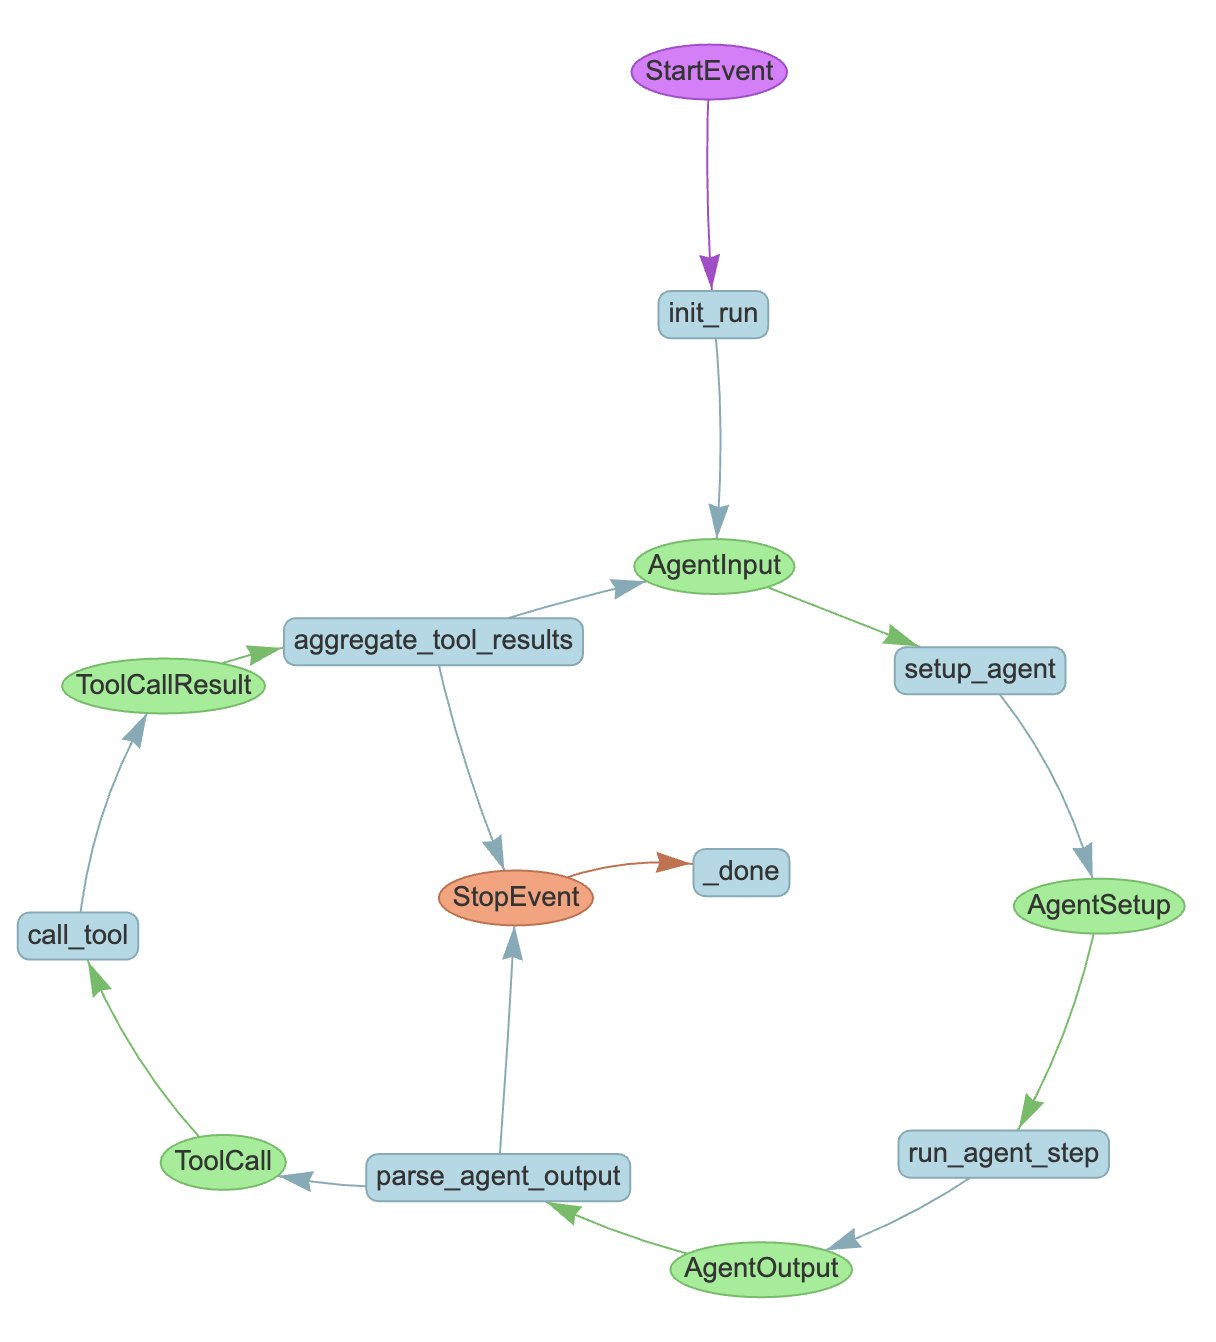

 To get a human in the loop, we'll get our tool to emit a specific kind of event that isn't received by any other step in the workflow. We'll then tell our tool to wait until it receives a specific kind of "reply" event.

To do this, we use the built-in `InputRequiredEvent` and `HumanResponseEvent` events to use for this purpose. These events expect human input in the form of a simple string. If you want to capture more nuanced forms of human input, you can subclass these events to match the needs of your application.

In [15]:
from llama_index.core.workflow import (
    Context,
    InputRequiredEvent,
    HumanResponseEvent,
)

# a tool that performs a dangerous task
async def dangerous_task(ctx: Context) -> str:
    """A dangerous task that requires human confirmation."""

    # emits an InputRequiredEvent,
    # then waits until we see a HumanResponseEvent
    response = await ctx.wait_for_event(
        HumanResponseEvent,
        waiter_event=InputRequiredEvent(
            prefix="Are you sure you want to proceed? ",
            user_name="Laurie",
        ),
        requirements={"user_name": "Laurie"}
    )

    # act on the input from the event
    if response.response.strip().lower() == "yes":
        return "Dangerous task completed successfully."
    else:
        return "Dangerous task aborted."


workflow = AgentWorkflow.from_tools_or_functions(
    [dangerous_task],
    llm=llm,
    system_prompt="You are a helpful assistant that can perform dangerous tasks.",
)

To capture the event, we use the same streaming interface we used earlier and look for an `InputRequiredEvent`. Then we can use `input` to capture a response from the user, and send it back using the `send_event` method.

In [16]:
handler = workflow.run(user_msg="I want to proceed with the dangerous task.")

async for event in handler.stream_events():
    # capture InputRequiredEvent
    if isinstance(event, InputRequiredEvent):
        # capture keyboard input
        response = input(event.prefix)
        # send our response back
        handler.ctx.send_event(
            HumanResponseEvent(
                response=response,
                user_name=event.user_name,
            )
        )

response = await handler
print(str(response))

Are you sure you want to proceed? no
The dangerous task has been aborted. If you want to proceed with it, please confirm again.


## Congratulations!

You've created your first agent. But `AgentWorkflow`s can do more than single agents; they can also create teams of agents that work together, a very flexible and powerful pattern. Let's see how that works by creating a system that can generate a report on a given topic.

# Multi-agent System with AgentWorkflow

Our system will have three agents:

1. A `ResearchAgent` that will search the web for information on the given topic.
2. A `WriteAgent` that will write the report using the information found by the `ResearchAgent`.
3. A `ReviewAgent` that will review the report and provide feedback.

We will use the `AgentWorkflow` class to create a multi-agent system that will execute these agents in order.

There are a lot of ways we could go about building a system to perform this task. In this example, we will use a few tools to help with the research and writing processes.

1. A `web_search` tool to search the web for information on the given topic.
2. A `record_notes` tool which will save research found on the web to the state so that the other tools can use it.
3. A `write_report` tool to write the report using the information found by the `ResearchAgent`
4. A `review_report` tool to review the report and provide feedback.

Utilizing the `Context` class, we can pass state between agents, and each agent will have access to the current state of the system.


We'll use the same Tavily tool we used in our basic agent to help us again.

In [17]:
async def search_web(query: str) -> str:
    """Useful for using the web to answer questions."""
    client = AsyncTavilyClient(api_key=tavily_api_key)
    return str(await client.search(query))

async def record_notes(ctx: Context, notes: str, notes_title: str) -> str:
    """Useful for recording notes on a given topic."""
    current_state = await ctx.get("state")
    if "research_notes" not in current_state:
        current_state["research_notes"] = {}
    current_state["research_notes"][notes_title] = notes
    await ctx.set("state", current_state)
    return "Notes recorded."

async def write_report(ctx: Context, report_content: str) -> str:
    """Useful for writing a report on a given topic."""
    current_state = await ctx.get("state")
    current_state["report_content"] = report_content
    await ctx.set("state", current_state)
    return "Report written."


async def review_report(ctx: Context, review: str) -> str:
    """Useful for reviewing a report and providing feedback."""
    current_state = await ctx.get("state")
    current_state["review"] = review
    await ctx.set("state", current_state)
    return "Report reviewed."

With our tools defined, we can now create our agents.

If the LLM you are using supports tool calling (most big models do), you can use the `FunctionAgent` class, which is a little more efficient. Otherwise, you can use the `ReActAgent` class.

Here, the name and description of each agent is used so that the system knows what each agent is responsible for and when to hand off control to the next agent.

Like our single-agent system did before, each agent takes a `system_prompt` that tells it what it should do, and suggests how to work with the other agents.

You can also optionally help your multi-agent system constrain itself by listing which other agents an agent can talk to using `can_handoff_to` (otherwise it will just try to figure this out on its own).

In [18]:
from llama_index.core.agent.workflow import FunctionAgent, ReActAgent

research_agent = FunctionAgent(
    name="ResearchAgent",
    description="Useful for searching the web for information on a given topic and recording notes on the topic.",
    system_prompt=(
        "You are the ResearchAgent that can search the web for information on a given topic and record notes on the topic. "
        "Once notes are recorded and you are satisfied, you should hand off control to the WriteAgent to write a report on the topic."
    ),
    llm=llm,
    tools=[search_web, record_notes],
    can_handoff_to=["WriteAgent"],
)

write_agent = FunctionAgent(
    name="WriteAgent",
    description="Useful for writing a report on a given topic.",
    system_prompt=(
        "You are the WriteAgent that can write a report on a given topic. "
        "Your report should be in a markdown format. The content should be grounded in the research notes. "
        "Once the report is written, you should get feedback at least once from the ReviewAgent."
    ),
    llm=llm,
    tools=[write_report],
    can_handoff_to=["ReviewAgent", "ResearchAgent"],
)

review_agent = FunctionAgent(
    name="ReviewAgent",
    description="Useful for reviewing a report and providing feedback.",
    system_prompt=(
        "You are the ReviewAgent that can review a report and provide feedback. "
        "Your feedback should either approve the current report or request changes for the WriteAgent to implement."
    ),
    llm=llm,
    tools=[review_report],
    can_handoff_to=["ResearchAgent","WriteAgent"],
)

## Running the Workflow

With our agents defined, we can create our `AgentWorkflow` and run it. Since this is a multi-agent system, instantiating it looks a little different. Instead of using the `from_tools_or_functions` helper, we instantiate it directly. It takes these arguments:
* an array of agents
* the name of the agent that it should start with (this will receive the initial `user_msg`)
* an `initial_state` which populates the context variable `state` we mentioned earlier

In [19]:
from llama_index.core.agent.workflow import AgentWorkflow

agent_workflow = AgentWorkflow(
    agents=[research_agent, write_agent, review_agent],
    root_agent=research_agent.name,
    initial_state={
        "research_notes": {},
        "report_content": "Not written yet.",
        "review": "Review required.",
    },
)

As the workflow is running, we will stream the events to get an idea of what is happening under the hood. We've added some decoration to the output to make this a little easier to read.

In [20]:
from llama_index.core.agent.workflow import (
    AgentInput,
    AgentOutput,
    ToolCall,
    ToolCallResult,
    AgentStream,
)

handler = agent_workflow.run(
    user_msg="""Write me a report on the history of the web.
      Briefly describe the history of the world wide web, including
      the development of the internet and the development of the web,
      including 21st century developments"""
)

current_agent = None
current_tool_calls = ""
async for event in handler.stream_events():
    if (
        hasattr(event, "current_agent_name")
        and event.current_agent_name != current_agent
    ):
        current_agent = event.current_agent_name
        print(f"\n{'='*50}")
        print(f"🤖 Agent: {current_agent}")
        print(f"{'='*50}\n")
    elif isinstance(event, AgentOutput):
        if event.response.content:
            print("📤 Output:", event.response.content)
        if event.tool_calls:
            print(
                "🛠️  Planning to use tools:",
                [call.tool_name for call in event.tool_calls],
            )
    elif isinstance(event, ToolCallResult):
        print(f"🔧 Tool Result ({event.tool_name}):")
        print(f"  Arguments: {event.tool_kwargs}")
        print(f"  Output: {event.tool_output}")
    elif isinstance(event, ToolCall):
        print(f"🔨 Calling Tool: {event.tool_name}")
        print(f"  With arguments: {event.tool_kwargs}")


🤖 Agent: ResearchAgent

🛠️  Planning to use tools: ['search_web']
🔨 Calling Tool: search_web
  With arguments: {'query': 'history of the world wide web including development of the internet and 21st century developments'}
🔧 Tool Result (search_web):
  Arguments: {'query': 'history of the world wide web including development of the internet and 21st century developments'}
  Output: {'query': 'history of the world wide web including development of the internet and 21st century developments', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'History of the Internet and World Wide Web (WWW)', 'url': 'https://www.encyclopedia.com/economics/encyclopedias-almanacs-transcripts-and-maps/history-internet-and-world-wide-web-www', 'content': 'Perhaps the invention that most facilitated the growth of the Internet as a global information-sharing system is the World Wide Web. Unlike the Internet, however, the early design and development of the World Wide Web was prim

Now we can see the final output:

In [21]:
state = await handler.ctx.get("state")
print(state["report_content"])

# History of the World Wide Web

The history of the World Wide Web is closely intertwined with the development of the Internet, both of which have profoundly transformed global communication and information exchange.

## Development of the Internet

The Internet originated from research projects funded by the U.S. federal government, notably ARPANET, which was the first operational packet-switching network and served as the precursor to the modern Internet. The Internet is essentially a vast collection of interconnected computer networks that use standard protocols to exchange information.

## Invention of the World Wide Web

The World Wide Web was primarily developed by Tim Berners-Lee in 1990 while he was working at CERN, the European Laboratory for Particle Physics. Berners-Lee proposed a global interactive interface for the Internet to make it more accessible and seamless. He developed the standards for addressing, linking language (HTML), and transferring multimedia documents, ena

And also what the reviewer agent thought. The reviewer agent could have decided to hand back control to the `WriteAgent` to try again, but in this case it did not.

In [22]:
print(state["review"])

The report provides a clear and concise overview of the history of the World Wide Web, including the development of the Internet and key 21st century developments. It accurately covers the origins of the Internet with ARPANET, the invention of the Web by Tim Berners-Lee at CERN, and the significance of releasing the Web code into the public domain in 1993. The report also effectively summarizes the evolution of the Web through Web 2.0, Web 3.0, and the Semantic Web, highlighting important technologies and their impact.

The structure is logical, starting with the Internet's background, moving to the Web's invention, and concluding with modern developments. The language is clear and accessible, suitable for a general audience.

Overall, the report meets the requirements and provides a well-rounded summary of the topic. No major changes are necessary.


## Congratulations again!

You've successfully put together a multi-agent system using `AgentWorkflow`. `AgentWorkflow` is designed to be a simple jumping-off point for putting together a team of agents to solve a problem. But LlamaIndex can do even more!

# Building agentic workflows from scratch

As mentioned, `AgentWorkflow` is a pre-built `Workflow`, so you've already encountered many of the concepts you need to build a workflow from scratch.

You can easily build your own workflows directly to create multi-agent systems that are customized to your needs. There's a number of reasons you might want to branch out from AgentWorkflow to rolling your own workflow:

* **Fine-grained flow control**: Workflows allow looping, branching, parallel calls and map-reduce behavior. Workflows allow you to precisely specify how data gets passed around your system.

* **Structured inputs and outputs**: If you want your inputs and outputs to be richer than simple strings, or to kick off with more than just a `user_msg`, workflows allow you to do that.

* **Multimodality**: LlamaIndex can handle more than just text! You can handle images, audio and video as well.

* **Query planning**: a custom workflow can execute complex planning of how to run based on its inputs, rather than immediately jumping into a team.

* **Reflection**: A powerful technique for agents is their ability to examine their own output and decide whether it's sufficient, or if they need to try again. Using looping, you can implement this pattern.


## Creating a new workflow

Under the hood, Workflows are regular Python classes. They are defined as a series of `steps`, each of which receives certain classes of events and emits certain classes of events.

Here's the most basic form of a workflow, with a single step:

In [23]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

class MyWorkflow(Workflow):
    @step
    async def my_step(self, ev: StartEvent) -> StopEvent:
        # do something here
        return StopEvent(result="Hello, world!")

This new `MyWorkflow` class:
* Uses the `@step` decorator to declare a function to be a step
* Has a single step called `my_step` which accepts a `StartEvent`. `StartEvent` is a special event which is always generated when a workflow first runs.
* `my_step` returns a `StopEvent`, which is another special event. When a `StopEvent` is emitted the workflow returns it and stops running.

You instantiate it and run it just like you ran the the `AgentWorkflow`:

In [24]:
workflow = MyWorkflow(timeout=10, verbose=False)
result = await workflow.run()
print(result)

Hello, world!


## Type annotations for steps

The type annotations (e.g. `ev: StartEvent` and `-> StopEvent`) are essential to the way Workflows work. The expected types determine what event types will trigger a step. Tools like the visualizer (see later) also rely on these annotations to determine what types are generated and therefore where control flow goes next.

## Aside: running a workflow in regular python

Workflows are async by default, so you use `await` to get the result of the `run` command. This will work fine in a notebook environment; in a vanilla python script you will need to import `asyncio` and wrap your code in an async function, like this:

```
async def main():
    w = MyWorkflow(timeout=10, verbose=False)
    result = await w.run()
    print(result)


if __name__ == "__main__":
    import asyncio
    asyncio.run(main())
```

Since we're in a notebook right now, we won't execute the above code as it won't work!

## Visualizing a workflow

A great feature of workflows is the built-in visualizer, which we will install now:


In [25]:
!pip install llama-index-utils-workflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00


Let's visualize the simple workflow we just created:

In [26]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(MyWorkflow, filename="basic_workflow.html")

basic_workflow.html


This creates a file called `basic_workflow.html` in the notebook's file system. You can open up the file pane and download the file, then open it in your browser. You'll see something like this:

<img width="500" src="https://seldo.com/uploads/2025/basic_flow.png">

Of course, a flow with a single step is not very useful! Let's define a multi-step workflow.

## Custom Events

Multiple steps are created by defining custom events that can be emitted by steps and trigger other steps. Let's define a simple 3-step workflow by defining two custom events, `FirstEvent` and `SecondEvent`. These classes can have any names and properties, but must inherit from `Event`:


In [27]:
from llama_index.core.workflow import Event

class FirstEvent(Event):
    first_output: str

class SecondEvent(Event):
    second_output: str

## Defining the workflow

Now we define the workflow itself. We do this by defining the input and output types on each step.

* `step_one` takes a `StartEvent` and returns a `FirstEvent`
* `step_two` takes a `FirstEvent` and returns a `SecondEvent`
* `step_three` takes a `SecondEvent` and returns a `StopEvent`

In [28]:
class MyWorkflow(Workflow):
    @step
    async def step_one(self, ev: StartEvent) -> FirstEvent:
        print(ev.first_input)
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ev: FirstEvent) -> SecondEvent:
        print(ev.first_output)
        return SecondEvent(second_output="Second step complete.")

    @step
    async def step_three(self, ev: SecondEvent) -> StopEvent:
        print(ev.second_output)
        return StopEvent(result="Workflow complete.")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run(first_input="Start the workflow.")
print(result)

Start the workflow.
First step complete.
Second step complete.
Workflow complete.


If we run this through the visualizer, we'll get something like this:

<img width="500" src="https://seldo.com/uploads/2025/multi_step.png">

## Looping

However, there's not much point to a workflow if it just runs straight through! A key feature of Workflows is their enablement of branching and looping logic, more simply and flexibly than graph-based approaches. To enable looping, we'll create a new `LoopEvent` (LoopEvent is not special, any event can be used to loop).

In [29]:
class LoopEvent(Event):
    first_input: str

Now we'll edit our `step_two` to make a random decision about whether to execute serially or loop back:

In [30]:
import random

class MyWorkflow(Workflow):

    # step_one will trigger on a StartEvent or a LoopEvent
    @step
    async def step_one(self, ev: StartEvent | LoopEvent) -> FirstEvent:
        print(ev.first_input)
        return FirstEvent(first_output="First step complete")

    # step two returns either a SecondEvent or a LoopEvent
    @step
    async def step_two(self, ev: FirstEvent) -> SecondEvent | LoopEvent:
        print(ev.first_output)
        if random.randint(0, 1) == 0:
            print("Bad thing happened")
            return LoopEvent(first_input="Back to step one.")
        else:
            print("Good thing happened")
            return SecondEvent(second_output="Second step complete.")

    @step
    async def step_three(self, ev: SecondEvent) -> StopEvent:
        print(ev.second_output)
        return StopEvent(result="Workflow complete.")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run(first_input="Start the workflow.")
print(result)

Start the workflow.
First step complete
Good thing happened
Second step complete.
Workflow complete.


Note the new type annotations on `step_one`: we now accept either a `StartEvent` or a `LoopEvent` to trigger the step. In step two, we emit either a `SecondEvent` or a `LoopEvent`.

In this run, the "bad" outcome happened once, repeating step one, then the "good" outcome happened, allowing the workflow to complete.

Our new, looping workflow visualizes like this:

<img width="600" src="https://seldo.com/uploads/2025/Screenshot%202025-05-04%20at%203.41.03%E2%80%AFPM.png">

## Branching

The same constructs that allow us to loop allow us to create branches. Here's a workflow that executes two different branches depending on an early decision:

In [31]:
class BranchA1Event(Event):
    payload: str


class BranchA2Event(Event):
    payload: str


class BranchB1Event(Event):
    payload: str


class BranchB2Event(Event):
    payload: str


class BranchWorkflow(Workflow):
    @step
    async def start(self, ev: StartEvent) -> BranchA1Event | BranchB1Event:
        if random.randint(0, 1) == 0:
            print("Go to branch A")
            return BranchA1Event(payload="Branch A")
        else:
            print("Go to branch B")
            return BranchB1Event(payload="Branch B")

    @step
    async def step_a1(self, ev: BranchA1Event) -> BranchA2Event:
        print(ev.payload)
        return BranchA2Event(payload=ev.payload)

    @step
    async def step_b1(self, ev: BranchB1Event) -> BranchB2Event:
        print(ev.payload)
        return BranchB2Event(payload=ev.payload)

    @step
    async def step_a2(self, ev: BranchA2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch A complete.")

    @step
    async def step_b2(self, ev: BranchB2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch B complete.")

It visualizes like this:

<img width="700" src="https://seldo.com/uploads/2025/branching.png">

## Concurrent execution

The final form of flow control you can implement in workflows is concurrent execution. This allows you to efficiently run long-running tasks in parallel, and gather them together when they are needed. This can also let you perform map-reduce style tasks.

To do this, we'll be using the `Context` object that we already encountered when working with `AgentWorkflow`. The `Context` is available to every step in a workflow: to access it, declare it as an argument to your step and it will be automatically populated.

In this example, we use a new method, `Context.send_event` rather than returning an event. This allows us to emit multiple events in parallel rather than returning just one as we have previously.

In [32]:
import asyncio

class StepTwoEvent(Event):
    query: str

class ParallelFlow(Workflow):
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> StepTwoEvent:
        ctx.send_event(StepTwoEvent(query="Query 1"))
        ctx.send_event(StepTwoEvent(query="Query 2"))
        ctx.send_event(StepTwoEvent(query="Query 3"))

    @step(num_workers=4)
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StopEvent:
        print("Running slow query ", ev.query)
        await asyncio.sleep(random.randint(1, 5))

        return StopEvent(result=ev.query)

In [33]:
w = ParallelFlow(timeout=10, verbose=False)
result = await w.run(message="Start the workflow.")
print(result)

Running slow query  Query 1
Running slow query  Query 2
Running slow query  Query 3
Query 3


As you can see, it executes all 3 queries. The first one to complete emits a StopEvent, at which point the workflow halts without waiting for the other 2 events.

## Collecting events

But what if we do want the output of all 3 events? Another method, `Context.collect_events`, exists for that purpose:

In [34]:
class StepThreeEvent(Event):
    result: str

class ConcurrentFlow(Workflow):
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> StepTwoEvent:
        ctx.send_event(StepTwoEvent(query="Query 1"))
        ctx.send_event(StepTwoEvent(query="Query 2"))
        ctx.send_event(StepTwoEvent(query="Query 3"))

    @step(num_workers=4)
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StepThreeEvent:
        print("Running query ", ev.query)
        await asyncio.sleep(random.randint(1, 5))
        return StepThreeEvent(result=ev.query)

    @step
    async def step_three(self, ctx: Context, ev: StepThreeEvent) -> StopEvent:
        # wait until we receive 3 events
        result = ctx.collect_events(ev, [StepThreeEvent] * 3)
        if result is None:
            print("Not all events received yet.")
            return None

        # do something with all 3 results together
        print(result)
        return StopEvent(result="Done")

In [35]:
w = ConcurrentFlow(timeout=10, verbose=False)
result = await w.run(message="Start the workflow.")
print(result)

Running query  Query 1
Running query  Query 2
Running query  Query 3
Not all events received yet.
Not all events received yet.
[StepThreeEvent(result='Query 1'), StepThreeEvent(result='Query 2'), StepThreeEvent(result='Query 3')]
Done


In the above example, we emit three `StepTwoEvent`s which trigger `step_two`, each execution of which eventually emits a `StepThreeEvent`.

`step_three` gets triggered whenever a `StepThreeEvent` fires. What `collect_events` does is store the events in the context until it has collected the number and type of events specified in its second argument. In this case, we've told it to wait for 3 events.

If an event fires and `collect_events` hasn't yet seen the right number of events, it returns `None`, so we tell `step_three` to do nothing in that case. When `collect_events` receives the right number of events it returns them as an array, which you can see us printing in the final output. Note that in the array they are stored in the order they returned, not the order they were emitted.

To implement a map-reduce pattern, you would split your task up into as many steps as necessary, and use `Context` to store that number with `ctx.set("num_events", some_number)`. Then in `step_three` you would wait for the number stored in the context using `await ctx.get("num_events")`. So you don't need to know in advance exactly how many concurrent steps you're taking.

## Collecting different event types

We don't just have to wait for multiple events of the same kind. In this example, we'll emit 3 totally different events and collect them at the end.

In [36]:
class StepAEvent(Event):
    query: str

class StepACompleteEvent(Event):
    result: str

class StepBEvent(Event):
    query: str

class StepBCompleteEvent(Event):
    result: str

class StepCEvent(Event):
    query: str

class StepCCompleteEvent(Event):
    result: str

class ConcurrentFlow(Workflow):
    @step
    async def start(
        self, ctx: Context, ev: StartEvent
    ) -> StepAEvent | StepBEvent | StepCEvent:
        ctx.send_event(StepAEvent(query="Query 1"))
        ctx.send_event(StepBEvent(query="Query 2"))
        ctx.send_event(StepCEvent(query="Query 3"))

    @step
    async def step_a(self, ctx: Context, ev: StepAEvent) -> StepACompleteEvent:
        print("Doing something A-ish")
        return StepACompleteEvent(result=ev.query)

    @step
    async def step_b(self, ctx: Context, ev: StepBEvent) -> StepBCompleteEvent:
        print("Doing something B-ish")
        return StepBCompleteEvent(result=ev.query)

    @step
    async def step_c(self, ctx: Context, ev: StepCEvent) -> StepCCompleteEvent:
        print("Doing something C-ish")
        return StepCCompleteEvent(result=ev.query)

    @step
    async def step_three(
        self,
        ctx: Context,
        ev: StepACompleteEvent | StepBCompleteEvent | StepCCompleteEvent,
    ) -> StopEvent:
        print("Received event ", ev.result)

        # wait until we receive 3 events
        events = ctx.collect_events(
            ev,
            [StepCCompleteEvent, StepACompleteEvent, StepBCompleteEvent],
        )
        if (events is None):
            return None

        # do something with all 3 results together
        print("All events received: ", events)
        return StopEvent(result="Done")

When we run, it will do all three things and wait for them in `step_three`.

In [37]:
w = ConcurrentFlow(timeout=10, verbose=False)
result = await w.run(message="Start the workflow.")
print(result)

Doing something A-ish
Doing something B-ish
Doing something C-ish
Received event  Query 1
Received event  Query 2
Received event  Query 3
All events received:  [StepCCompleteEvent(result='Query 3'), StepACompleteEvent(result='Query 1'), StepBCompleteEvent(result='Query 2')]
Done


Note that the order of the events is significant: `collect_events` was told to expect Step C, then A, then B, and that's the order they are in the return array.

These changes have a pretty pleasing visualization:

<img width="700" src="https://seldo.com/uploads/2025/different_events.png">

## Streaming

We already saw `AgentWorkflow` emit a stream of events that we could handle and filter when we run the event. Let's see how those get emitted in this example, using `Context.write_event_to_stream`:

In [38]:
class FirstEvent(Event):
    first_output: str

class SecondEvent(Event):
    second_output: str
    response: str

class TextEvent(Event):
    delta: str

class ProgressEvent(Event):
    msg: str

class MyWorkflow(Workflow):
    @step
    async def step_one(self, ctx: Context, ev: StartEvent) -> FirstEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step one is happening"))
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ctx: Context, ev: FirstEvent) -> SecondEvent:
        llm = OpenAI(classifier="gpt-4.1-mini", api_key=api_key) # the OpenAI key we set up at the beginning
        generator = await llm.astream_complete(
            "Please give me the first 50 words of Moby Dick, a book in the public domain."
        )
        async for response in generator:
            # Allow the workflow to stream this piece of response
            ctx.write_event_to_stream(TextEvent(delta=response.delta))
        return SecondEvent(
            second_output="Second step complete, full response attached",
            response=str(response),
        )

    @step
    async def step_three(self, ctx: Context, ev: SecondEvent) -> StopEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step three is happening"))
        return StopEvent(result="Workflow complete.")

We handle this output exactly the same way we did for `AgentWorkflow`:

In [39]:
workflow = MyWorkflow(timeout=30, verbose=False)
handler = workflow.run(first_input="Start the workflow.")

async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print("\n"+ev.msg)
    if isinstance(ev, TextEvent):
        print(ev.delta, end="")

final_result = await handler
print("Final result = ", final_result)


Step one is happening
Certainly! Here are the first 50 words of *Moby-Dick* by Herman Melville:

"Call me Ishmael. Some years ago—never mind how long precisely—having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world. It is a way I have of driving off the spleen..."
Step three is happening
Final result =  Workflow complete.


## Congratulations yet again!

You've now put together a Workflow from scratch, and learned the primitives necessary to build any workflow.

# Putting together a multi-agent system

Now we've seen all the ways workflows can work, let's construct our own multi-agent system! This will be our Deep Research multi-agent system.

It will have three agents:
* `QuestionAgent` which accepts a research topic and generates a bunch of questions
* `AnswerAgent` which answers a specific question (we'll need to call it many times)
* `ReportAgent` which aggregates all the answers and generates a report.

We'll create these as `FunctionAgent`s, the same as we did when creating agents for `AgentWorkflow`.

In [40]:
question_agent = FunctionAgent(
    tools=[],
    llm=llm,
    verbose=False,
    system_prompt="""You are part of a deep research system.
      Given a research topic, you should come up with a bunch of questions
      that a separate agent will answer in order to write a comprehensive
      report on that topic. To make it easy to answer the questions separately,
      you should provide the questions one per line. Don't include markdown
      or any preamble in your response, just a list of questions."""
)
answer_agent = FunctionAgent(
    tools=[search_web],
    llm=llm,
    verbose=False,
    system_prompt="""You are part of a deep research system.
      Given a specific question, your job is to come up with a deep answer
      to that question, which will be combined with other answers on the topic
      into a comprehensive report. You can search the web to get information
      on the topic, as many times as you need."""
)
report_agent = FunctionAgent(
    tools=[],
    llm=llm,
    verbose=False,
    system_prompt="""You are part of a deep research system.
      Given a set of answers to a set of questions, your job is to combine
      them all into a comprehensive report on the topic."""
)

The Workflow we'll need to handle this task needs to do a few things:
* Accept the topic and pass it to the QuestionAgent
* Take all the answers from the QuestionAgent and split them up, firing off one AnswerAgent for each question
* Aggregate all the questions and answers from the AnswerAgents
* Generate a single report from them

In [41]:
class GenerateEvent(Event):
    research_topic: str

class QuestionEvent(Event):
    question: str

class AnswerEvent(Event):
    question: str
    answer: str

class ProgressEvent(Event):
    msg: str

class DeepResearchWorkflow(Workflow):

    @step
    async def setup(self, ctx: Context, ev: StartEvent) -> GenerateEvent:
        self.question_agent = ev.question_agent
        self.answer_agent = ev.answer_agent
        self.report_agent = ev.report_agent

        ctx.write_event_to_stream(ProgressEvent(msg="Starting research"))

        return GenerateEvent(research_topic=ev.research_topic)

    @step
    async def generate_questions(self, ctx: Context, ev: GenerateEvent) -> QuestionEvent:

        await ctx.set("research_topic", ev.research_topic)
        ctx.write_event_to_stream(ProgressEvent(msg=f"Research topic is {ev.research_topic}"))

        result = await self.question_agent.run(user_msg=f"""Generate some questions
          on the topic <topic>{ev.research_topic}</topic>.""")

        # some basic string manipulation to get separate questions
        lines = str(result).split("\n")
        questions = [line.strip() for line in lines if line.strip() != ""]

        # record how many answers we're going to need to wait for
        await ctx.set("total_questions", len(questions))

        # fire off multiple Answer Agents
        for question in questions:
            ctx.send_event(QuestionEvent(question=question))

    @step
    async def answer_question(self, ctx: Context, ev: QuestionEvent) -> AnswerEvent:

        result = await self.answer_agent.run(user_msg=f"""Research the answer to this
          question: <question>{ev.question}</question>. You can use web
          search to help you find information on the topic, as many times
          as you need. Return just the answer without preamble or markdown.""")

        ctx.write_event_to_stream(ProgressEvent(msg=f"""Received question {ev.question}
            Came up with answer: {str(result)}"""))

        return AnswerEvent(question=ev.question,answer=str(result))

    @step
    async def write_report(self, ctx: Context, ev: AnswerEvent) -> StopEvent:

        research = ctx.collect_events(ev, [AnswerEvent] * await ctx.get("total_questions"))
        # if we haven't received all the answers yet, this will be None
        if research is None:
            ctx.write_event_to_stream(ProgressEvent(msg="Collecting answers..."))
            return None

        ctx.write_event_to_stream(ProgressEvent(msg="Generating report..."))

        # aggregate the questions and answers
        all_answers = ""
        for q_and_a in research:
            all_answers += f"Question: {q_and_a.question}\nAnswer: {q_and_a.answer}\n\n"

        # prompt the report
        result = await self.report_agent.run(user_msg=f"""You are part of a deep research system.
          You have been given a complex topic on which to write a report:
          <topic>{await ctx.get("research_topic")}.

          Other agents have already come up with a list of questions about the
          topic and answers to those questions. Your job is to write a clear,
          thorough report that combines all the information from those answers.

          Here are the questions and answers:
          <questions_and_answers>{all_answers}</questions_and_answers>""")

        return StopEvent(result=str(result))

Running it gets us a sequence of progress events plus our final report:

In [42]:
workflow = DeepResearchWorkflow(timeout=300)
handler = workflow.run(
    research_topic="History of San Francisco",
    question_agent=question_agent,
    answer_agent=answer_agent,
    report_agent=report_agent
)

async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg)

final_result = await handler
print("==== The report ====")
print(final_result)

Starting research
Research topic is History of San Francisco
Received question When and by whom was San Francisco founded?
            Came up with answer: San Francisco was founded on March 28, 1776, by Spanish explorer Juan Bautista de Anza, who selected the site for the Presidio in San Francisco, California. The Presidio was constructed later that year and served as an important location for Spanish colonization in California.
Received question What are the origins of San Francisco before European settlement?
            Came up with answer: Before European settlement, the area now known as San Francisco was inhabited by indigenous peoples, primarily the Ohlone people. The indigenous name for San Francisco was Ahwaste, meaning "place at the bay." The Ohlone were part of a contiguous set of bands living from south of the Golden Gate to San José. The earliest inhabitants' exact ancestry is unclear, but they lived in the region long before European explorers arrived. The geography and 

## Reflection

We now have a deep research agent! It comprehensively researches a topic for us before providing a detailed answer. But we can do better!

LLMs are capable of self-reflection: they can read their own work, critique it, and provide feedback, allowing them to take a second try when they fall short.

Let's add reflection to our deep research agent! This will involve several changes:

* In `research` we'll store the research into the context, since we might need to use it multiple times
* We'll tell `write` that it can be triggered by a `RewriteEvent` in addition to a `WriteEvent`
* If it's a `RewriteEvent` we'll add the review as feedback to the prompt
* `review` will be changed to optionally emit a `RewriteEvent`
* We'll get the LLM to decide if the review returned by the agent is a "bad" or "good" review

In [43]:
class FeedbackEvent(Event):
    feedback: str

class ReviewEvent(Event):
    report: str

review_agent = FunctionAgent(
    tools=[],
    llm=llm,
    verbose=False,
    system_prompt="""You are part of a deep research system.
      Your job is to review a report that's been written and suggest
      questions that could have been asked to produce a more comprehensive
      report than the current version, or to decide that the current
      report is comprehensive enough."""
)

class DeepResearchWithReflectionWorkflow(Workflow):

    @step
    async def setup(self, ctx: Context, ev: StartEvent) -> GenerateEvent:
        self.question_agent = ev.question_agent
        self.answer_agent = ev.answer_agent
        self.report_agent = ev.report_agent
        self.review_agent = ev.review_agent
        self.review_cycles = 0

        ctx.write_event_to_stream(ProgressEvent(msg="Starting research"))

        return GenerateEvent(research_topic=ev.research_topic)

    @step
    async def generate_questions(self, ctx: Context, ev: GenerateEvent | FeedbackEvent) -> QuestionEvent:

        await ctx.set("research_topic", ev.research_topic)
        ctx.write_event_to_stream(ProgressEvent(msg=f"Research topic is {ev.research_topic}"))

        prompt = f"""Generate some questions on the topic <topic>{ev.research_topic}</topic>."""

        if isinstance(ev, FeedbackEvent):
            ctx.write_event_to_stream(ProgressEvent(msg=f"Got feedback: {ev.feedback}"))
            prompt += f"""You have previously researched this topic and
                got the following feedback, consisting of additional questions
                you might want to ask: <feedback>{ev.feedback}</feedback>.
                Keep this in mind when formulating your questions."""

        result = await self.question_agent.run(user_msg=prompt)

        # some basic string manipulation to get separate questions
        lines = str(result).split("\n")
        questions = [line.strip() for line in lines if line.strip() != ""]

        # record how many answers we're going to need to wait for
        await ctx.set("total_questions", len(questions))

        # fire off multiple Answer Agents
        for question in questions:
            ctx.send_event(QuestionEvent(question=question))

    @step
    async def answer_question(self, ctx: Context, ev: QuestionEvent) -> AnswerEvent:

        result = await self.answer_agent.run(user_msg=f"""Research the answer to this
          question: <question>{ev.question}</question>. You can use web
          search to help you find information on the topic, as many times
          as you need. Return just the answer without preamble or markdown.""")

        ctx.write_event_to_stream(ProgressEvent(msg=f"""Received question {ev.question}
            Came up with answer: {str(result)}"""))

        return AnswerEvent(question=ev.question,answer=str(result))

    @step
    async def write_report(self, ctx: Context, ev: AnswerEvent) -> ReviewEvent:

        research = ctx.collect_events(ev, [AnswerEvent] * await ctx.get("total_questions"))
        # if we haven't received all the answers yet, this will be None
        if research is None:
            ctx.write_event_to_stream(ProgressEvent(msg="Collecting answers..."))
            return None

        ctx.write_event_to_stream(ProgressEvent(msg="Generating report..."))

        # aggregate the questions and answers
        all_answers = ""
        for q_and_a in research:
            all_answers += f"Question: {q_and_a.question}\nAnswer: {q_and_a.answer}\n\n"

        # prompt the report
        result = await self.report_agent.run(user_msg=f"""You are part of a deep research system.
          You have been given a complex topic on which to write a report:
          <topic>{await ctx.get("research_topic")}.

          Other agents have already come up with a list of questions about the
          topic and answers to those questions. Your job is to write a clear,
          thorough report that combines all the information from those answers.

          Here are the questions and answers:
          <questions_and_answers>{all_answers}</questions_and_answers>""")

        return ReviewEvent(report=str(result))

    @step
    async def review(self, ctx: Context, ev: ReviewEvent) -> StopEvent | FeedbackEvent:

        result = await self.review_agent.run(user_msg=f"""You are part of a deep research system.
          You have just written a report about the topic {await ctx.get("research_topic")}.
          Here is the report: <report>{ev.report}</report>
          Decide whether this report is sufficiently comprehensive.
          If it is, respond with just the string "ACCEPTABLE" and nothing else.
          If it needs more research, suggest some additional questions that could
          have been asked.""")

        self.review_cycles += 1

        # either it's okay or we've already gone through 3 cycles
        if str(result) == "ACCEPTABLE" or self.review_cycles >= 3:
            return StopEvent(result=ev.report)
        else:
            ctx.write_event_to_stream(ProgressEvent(msg="Sending feedback"))
            return FeedbackEvent(
                research_topic=await ctx.get("research_topic"),
                feedback=str(result)
            )

In [46]:
workflow = DeepResearchWithReflectionWorkflow(timeout=500)
handler = workflow.run(
    research_topic="History of San Francisco",
    question_agent=question_agent,
    answer_agent=answer_agent,
    report_agent=report_agent,
    review_agent=review_agent
)

async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg)

final_result = await handler
print("==== The report ====")
print(final_result)

Starting research
Research topic is History of San Francisco
Received question What are the origins of San Francisco before European settlement?
            Came up with answer: Before European settlement, the area now known as San Francisco was inhabited by indigenous peoples, primarily the Ohlone cultural group. The indigenous name for San Francisco was Ahwaste, meaning "place at the bay." The Ohlone people lived in a contiguous set of bands from south of the Golden Gate to San José, and their territory did not correspond to the later city or county boundaries. The earliest inhabitants' exact origins are unclear, but they were part of a long-standing indigenous presence in the region prior to European arrival.
Received question When and by whom was San Francisco first established as a settlement?
            Came up with answer: San Francisco was first established as a settlement in 1776 by Spanish colonists who founded a presidio and a mission at the site.
Received question Who were

In this run, we did three rounds of review! You can see the full looping workflow in the visualizer:

<img width="660" src="https://seldo.com/uploads/2025/Screenshot%202025-05-04%20at%205.39.32%E2%80%AFPM.png">

## One final congratulations!

You've come a long way in this notebook -- from a single agent flow, to a multi-agent `AgentWorkflow` all the way through to full `Workflows`, with fine-grained flow control and self-reflection. What will you build your multi-agent system to do?